In [1]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
    

In [2]:
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Label Mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (32, 32))    # LeNet-5는 32x32 입력 사용
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)


# dataset 분할 (train:validation = 5:1), test dataset은 emnist dataset에 있는 것으로 사용
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=47)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=47)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=47)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

In [3]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)
class LeNet5_relu(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))

# LeNet-5 모델 정의 (activation function : tanh)
class LeNet5_tanh(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='tanh', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='tanh', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='tanh', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='tanh'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))



In [4]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r1 = LeNet5_relu(input_shape,num_classes)
model_r1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 16, 16, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


KeyboardInterrupt: 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "le_net5_relu_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 2, 2, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 84)                  │           5,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,751 (69.34 KB)

 Trainable params: 17,751 (69.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.3953 - loss: 2.1398 - val_accuracy: 0.7802 - val_loss: 0.6723
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7211 - loss: 0.8611 - val_accuracy: 0.8146 - val_loss: 0.5455
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7683 - loss: 0.7161 - val_accuracy: 0.8297 - val_loss: 0.4877
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7891 - loss: 0.6443 - val_accuracy: 0.8416 - val_loss: 0.4525
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8032 - loss: 0.5960 - val_accuracy: 0.8444 - val_loss: 0.4438
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8143 - loss: 0.5651 - val_accuracy: 0.8470 - val_loss: 0.4412
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8196 - loss: 0.5437 - val_accuracy: 0.8456 - val_loss: 0.4334
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8240 - loss: 0

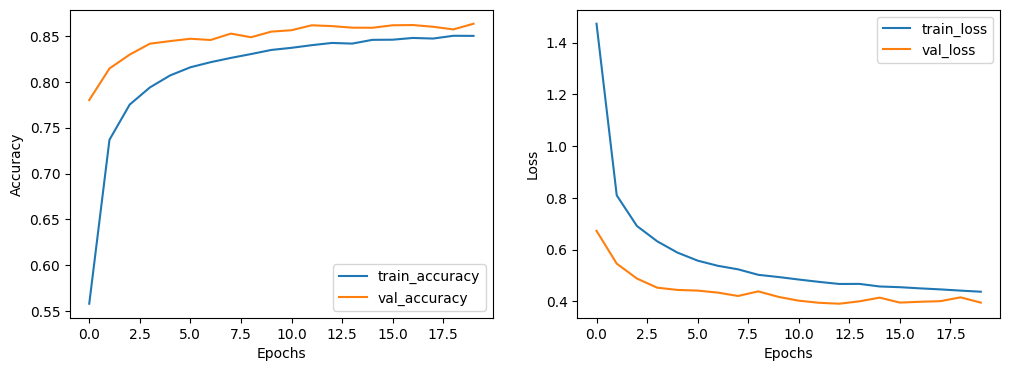

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8639 - loss: 0.3948
Test Loss: 0.4089, Test Accuracy: 0.8625
훈련시간 : 6.43 minutes.
평균 추론 시간: 0.0001 seconds.


In [5]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu, kernel 3,3 * 2)
class LeNet5_relu_1(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')) #kenel size 5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')) #kenel size 5,5 >> 3,3
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')) #kenel size 5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')) #kenel size 5,5 >> 3,3
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rk1 = LeNet5_relu_1(input_shape,num_classes)
model_rk1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rk1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

Model: "le_net5_relu_2_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 32, 32, 6)           │             906 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_16                 │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_17                 │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 2, 2, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 84)                  │           5,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,657 (72.88 KB)

 Trainable params: 18,657 (72.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4012 - loss: 2.1290 - val_accuracy: 0.7851 - val_loss: 0.6524
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7307 - loss: 0.8347 - val_accuracy: 0.8061 - val_loss: 0.5639
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7699 - loss: 0.7041 - val_accuracy: 0.8232 - val_loss: 0.5272
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7912 - loss: 0.6379 - val_accuracy: 0.8352 - val_loss: 0.4681
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8025 - loss: 0.5954 - val_accuracy: 0.8412 - val_loss: 0.4535
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8096 - loss: 0.5692 - val_accuracy: 0.8481 - val_loss: 0.4378
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8199 - loss: 0.5437 - val_accuracy: 0.8481 - val_loss: 0.4291
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8258 - loss: 0

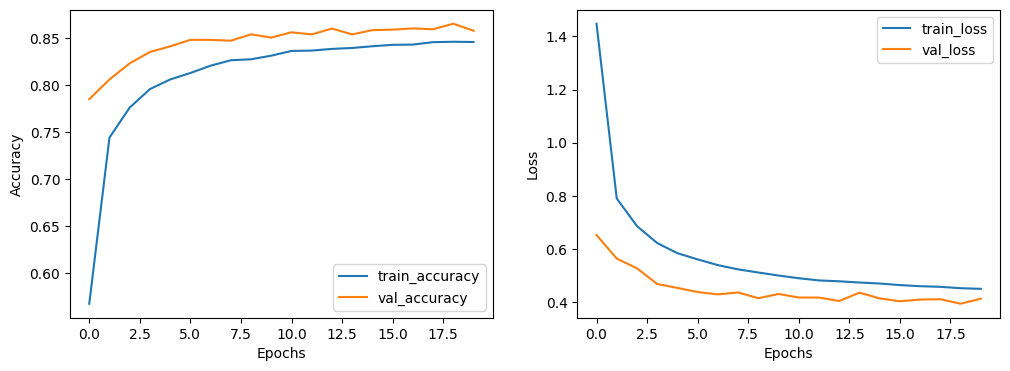

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8599 - loss: 0.4230
Test Loss: 0.4357, Test Accuracy: 0.8580
훈련시간 : 6.03 minutes.
평균 추론 시간: 0.0001 seconds.


In [11]:
tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (첫 conv layer 추가)
class LeNet5_relu_2(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))  #conv layer추가
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rkp1 = LeNet5_relu_2(input_shape,num_classes)
model_rkp1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rkp1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)                   │ (None, 32, 32, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 32, 32, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_22                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_23                 │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 2, 2, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 84)                  │           5,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,783 (77.28 KB)

 Trainable params: 19,783 (77.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.4140 - loss: 2.0912 - val_accuracy: 0.7791 - val_loss: 0.6687
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7337 - loss: 0.8365 - val_accuracy: 0.8245 - val_loss: 0.5200
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7712 - loss: 0.7036 - val_accuracy: 0.8370 - val_loss: 0.4710
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7933 - loss: 0.6250 - val_accuracy: 0.8438 - val_loss: 0.4519
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8076 - loss: 0.5835 - val_accuracy: 0.8500 - val_loss: 0.4260
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8153 - loss: 0.5555 - val_accuracy: 0.8504 - val_loss: 0.4289
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8234 - loss: 0.5307 - val_accuracy: 0.8499 - val_loss: 0.4199
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8291 - loss: 0

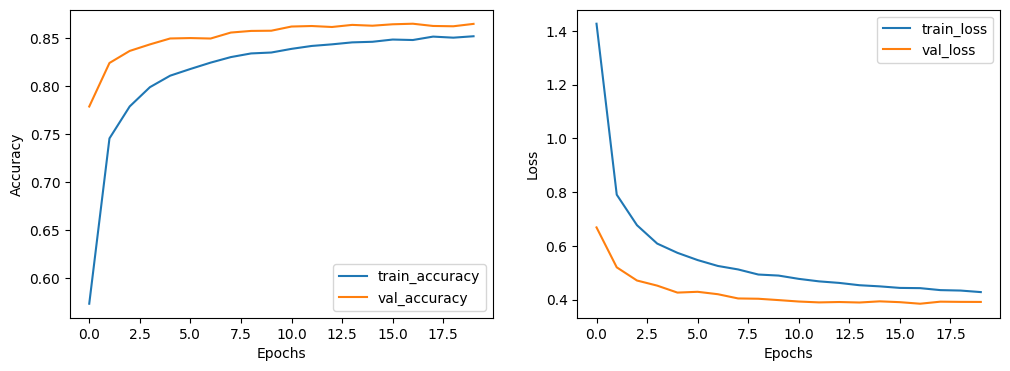

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8653 - loss: 0.3986
Test Loss: 0.4076, Test Accuracy: 0.8626
훈련시간 : 5.62 minutes.
평균 추론 시간: 0.0001 seconds.


In [14]:
tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (첫 conv 5,5 >> 3,3 * 2)
class LeNet5_relu_3(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape, padding="same")) #5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))  #conv layer 추가
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) #pooling layer 2,2 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rk3 = LeNet5_relu_3(input_shape,num_classes)
model_rk3.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rk3

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)                   │ (None, 32, 32, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 32, 32, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_24                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_25                 │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 2, 2, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 84)                  │           5,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 84)                  │           7,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,923 (105.17 KB)

 Trainable params: 26,923 (105.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.4028 - loss: 2.1197 - val_accuracy: 0.7730 - val_loss: 0.6545
Epoch 2/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.7132 - loss: 0.8890 - val_accuracy: 0.8109 - val_loss: 0.5444
Epoch 3/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7564 - loss: 0.7434 - val_accuracy: 0.8252 - val_loss: 0.5028
Epoch 4/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7770 - loss: 0.6713 - val_accuracy: 0.8341 - val_loss: 0.4637
Epoch 5/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7884 - loss: 0.6319 - val_accuracy: 0.8394 - val_loss: 0.4580
Epoch 6/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7996 - loss: 0.5892 - val_accuracy: 0.8387 - val_loss: 0.4565
Epoch 7/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8086 - loss: 0.5621 - val_accuracy: 0.8453 - val_loss: 0.4424
Epoch 8/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8150 - loss: 0

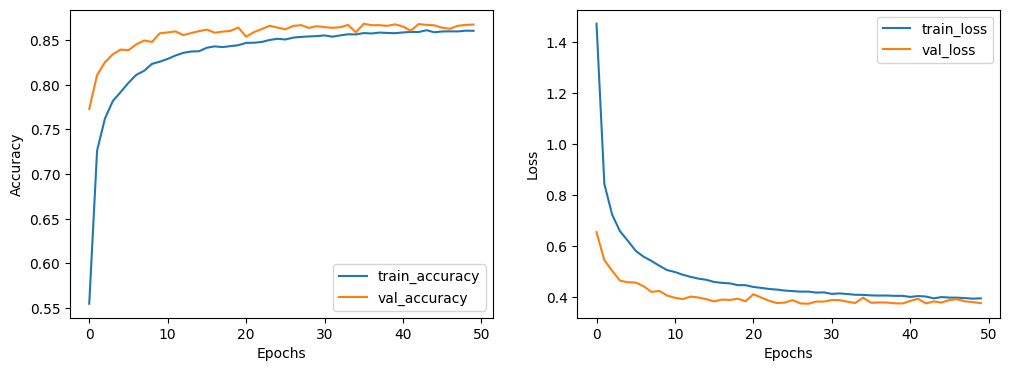

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8673 - loss: 0.3778
Test Loss: 0.3854, Test Accuracy: 0.8661
훈련시간 : 14.45 minutes.
평균 추론 시간: 0.0001 seconds.


In [15]:
# layer 확정모델
tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : dense layer 추가)
class LeNet5_relu_4(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape, padding="same")) #5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))  #conv layer 추가
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) #pooling layer 2,2 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(84,activation='relu')) #dense layer 추가
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rd1 = LeNet5_relu_4(input_shape,num_classes)
model_rd1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rd1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

Model: "le_net5_relu_5_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_83 (Conv2D)                   │ (None, 32, 32, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 32, 32, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_30                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_31                 │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 3, 3, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 1, 1, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 47)                  │           3,055 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,647 (166.59 KB)

 Trainable params: 42,647 (166.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.4093 - loss: 2.0254 - val_accuracy: 0.7514 - val_loss: 0.7365
Epoch 2/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.7326 - loss: 0.8068 - val_accuracy: 0.7962 - val_loss: 0.6086
Epoch 3/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7763 - loss: 0.6698 - val_accuracy: 0.8228 - val_loss: 0.4958
Epoch 4/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7938 - loss: 0.6007 - val_accuracy: 0.8288 - val_loss: 0.4871
Epoch 5/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8088 - loss: 0.5578 - val_accuracy: 0.8359 - val_loss: 0.4654
Epoch 6/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8195 - loss: 0.5252 - val_accuracy: 0.8330 - val_loss: 0.4607
Epoch 7/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8262 - loss: 0.5033 - val_accuracy: 0.8502 - val_loss: 0.4127
Epoch 8/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8313 - loss: 0

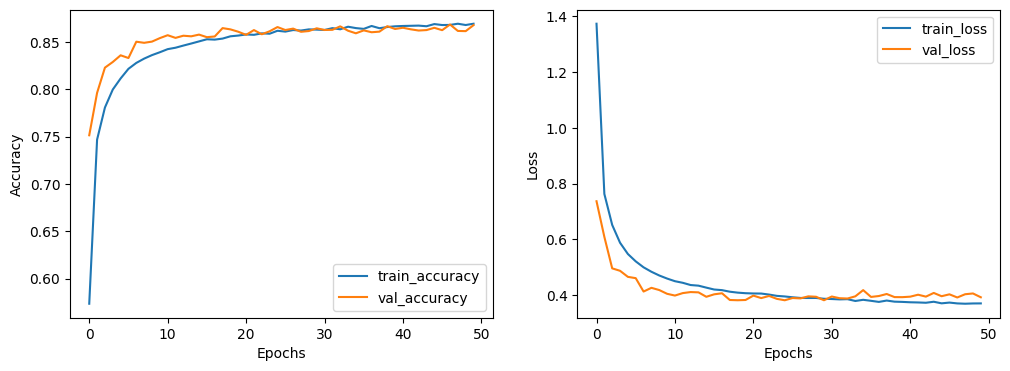

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8653 - loss: 0.3998
Test Loss: 0.4108, Test Accuracy: 0.8649
훈련시간 : 15.16 minutes.
평균 추론 시간: 0.0001 seconds.


In [18]:
tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (dense 뉴런 증가, dense 추가)
class LeNet5_relu_5(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape, padding="same")) #5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))  #conv layer 추가
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')) #conv layer 추가
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) #pooling layer 2,2 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(128, activation='relu')) #뉴런 증가
    self.add(Dropout(0.5))
    self.add(Dense(128,activation='relu'))
    self.add(Dense(64,activation='relu')) #dense layer 추가
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rd2 = LeNet5_relu_5(input_shape,num_classes)
model_rd2.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rd2

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu_4_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)                   │ (None, 32, 32, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 32, 32, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 2, 2, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 84)                  │           5,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 84)                  │           7,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,923 (105.17 KB)

 Trainable params: 26,923 (105.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.3932 - loss: 2.1115 - val_accuracy: 0.7798 - val_loss: 0.6651
Epoch 2/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7017 - loss: 0.9106 - val_accuracy: 0.8099 - val_loss: 0.5515
Epoch 3/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7516 - loss: 0.7529 - val_accuracy: 0.8222 - val_loss: 0.5104
Epoch 4/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7726 - loss: 0.6790 - val_accuracy: 0.8381 - val_loss: 0.4787
Epoch 5/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7896 - loss: 0.6275 - val_accuracy: 0.8405 - val_loss: 0.4598
Epoch 6/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8003 - loss: 0.5999 - val_accuracy: 0.8434 - val_loss: 0.4532
Epoch 7/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8057 - loss: 0.5755 - val_accuracy: 0.8431 - val_loss: 0.4477
Epoch 8/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8101 - loss: 0

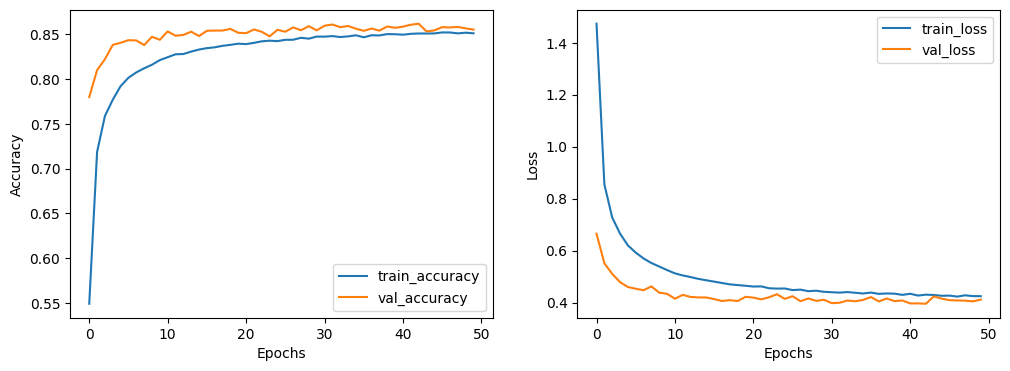

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8594 - loss: 0.4112
Test Loss: 0.4220, Test Accuracy: 0.8564
훈련시간 : 14.02 minutes.
평균 추론 시간: 0.0001 seconds.


In [19]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (average pooling > maxpooling)
class LeNet5_relu_4(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape, padding="same")) #5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))  #conv layer 추가
    self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) #pooling layer 2,2 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(84,activation='relu')) #dense layer 추가
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rd1 = LeNet5_relu_4(input_shape,num_classes)
model_rd1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rd1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 32, 32, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 32, 32, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_32                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_33                 │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 2, 2, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 84)                  │           5,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 84)                  │           7,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,307 (106.67 KB)

 Trainable params: 27,115 (105.92 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.4425 - loss: 1.9723 - val_accuracy: 0.8005 - val_loss: 0.5877
Epoch 2/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7440 - loss: 0.7820 - val_accuracy: 0.8222 - val_loss: 0.5179
Epoch 3/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7765 - loss: 0.6692 - val_accuracy: 0.8428 - val_loss: 0.4427
Epoch 4/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7928 - loss: 0.6128 - val_accuracy: 0.8524 - val_loss: 0.4206
Epoch 5/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8027 - loss: 0.5808 - val_accuracy: 0.8418 - val_loss: 0.4360
Epoch 6/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8109 - loss: 0.5586 - val_accuracy: 0.8565 - val_loss: 0.4049
Epoch 7/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8178 - loss: 0.5394 - val_accuracy: 0.8508 - val_loss: 0.4149
Epoch 8/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8197 - loss: 0

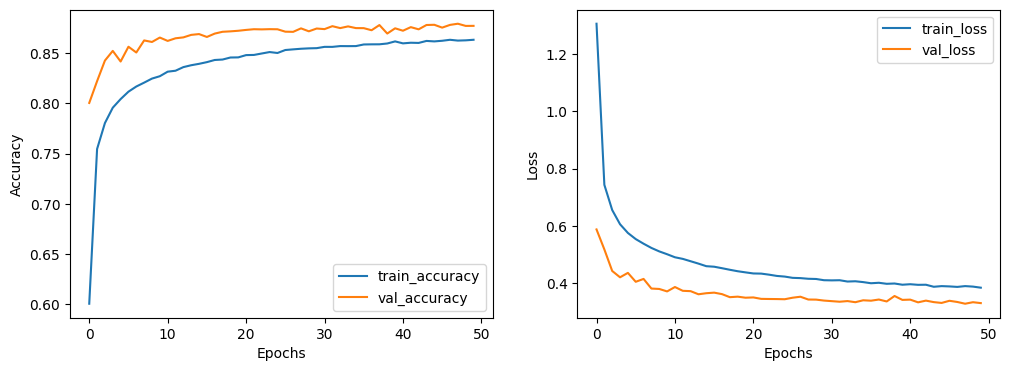

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8781 - loss: 0.3345
Test Loss: 0.3431, Test Accuracy: 0.8778
훈련시간 : 14.97 minutes.
평균 추론 시간: 0.0001 seconds.


In [20]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization

# layer 확정모델 + batch normalization
tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : dense layer 추가)
class LeNet5_relu_6(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape, padding="same")) #5,5 >> 3,3
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))  #conv layer 추가
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(BatchNormalization()) #
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) #pooling layer 2,2 >> 3,3
    self.add(BatchNormalization()) #
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(BatchNormalization()) #
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(84,activation='relu')) #dense layer 추가
    self.add(Dense(num_classes, activation='softmax'))

input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_rb1 = LeNet5_relu_6(input_shape,num_classes)
model_rb1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_rb1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

In [ ]:
#conv1은 5,5 1개로
#덴스 하나지우기
#배치 덴스 레이어에만 넣기
#드롭아웃 0.2